In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import chi2
import warnings


In [3]:
# Load data from file into array
data_in = np.genfromtxt('s0014_L1.txt', skip_header=6, delimiter='	')

print(data_in[1][0])

1.0


In [4]:
pixel = np.zeros(len(data_in))
wavelength = np.zeros(len(data_in))
darkref = np.zeros(len(data_in))
transref = np.zeros(len(data_in))
T1 = np.zeros(len(data_in))
T2 = np.zeros(len(data_in))
T3 = np.zeros(len(data_in))
T4 = np.zeros(len(data_in))
for i in range(len(data_in)):

    pixel[i] = data_in[i][0]
    wavelength[i] = data_in[i][1]
    darkref[i] = data_in[i][2]
    transref[i] = data_in[i][3]
## different trials (program takes image of spectra every 30 seconds)
    T1[i] = data_in[i][4]
    T2[i] = data_in[i][5]
    T3[i] = data_in[i][6]
    T4[i] = data_in[i][7]


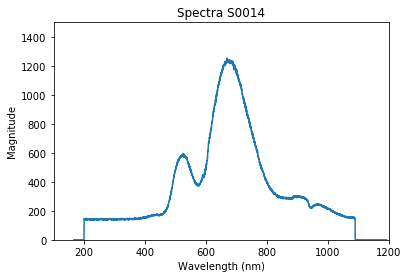

In [5]:
# Plot model with a solid line
plt.plot(wavelength,T2, '-');

# Set axis limits to include origin
plt.xlim(100,1200)
plt.ylim(0,1500);

# Add axis labels
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude');

# Add legend
## plt.legend(['Data','100 $\Omega$'])

# Add title
plt.title('Spectra S0014');

In [12]:
#load in all necessary data, since background and noise data is needed
s130 = np.genfromtxt('S130_L1.txt', skip_header = 6, delimiter = '	')
blankARraw = np.genfromtxt('BLANK_AR.txt', skip_header = 6, delimiter = '	')
blankBRraw = np.genfromtxt('BLANK_BR.txt', skip_header = 6, delimiter = '	')
std_corrARraw = np.genfromtxt('STD_AR.txt', skip_header = 6, delimiter = '	')
std_corrBRraw = np.genfromtxt('STD_BR.txt', skip_header = 6, delimiter = '	')
print(std_corrARraw)

[[0.000000e+00 1.662440e+02 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]
 [1.000000e+00 1.665140e+02 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]
 [2.000000e+00 1.667840e+02 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]
 ...
 [3.645000e+03 1.192546e+03 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]
 [3.646000e+03 1.192833e+03 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]
 [3.647000e+03 1.193121e+03 0.000000e+00 0.000000e+00 0.000000e+00
  0.000000e+00]]


In [21]:
image1 = np.zeros(len(s130))
image2 = np.zeros(len(s130))
wavel = np.zeros(len(s130))
blankAR = np.zeros(len(s130))
blankBR = np.zeros(len(s130))
std_corrAR = np.zeros(len(s130))
std_corrBR = np.zeros(len(s130))

## data before correction
for i in range(len(s130)):
    image1[i] = s130[i][4]
    image2[i] = s130[i][5] ## may want to average runs?
    wavel[i] = s130[i][1]
    blankAR[i] = blankARraw[i][4] ## average before and after?
    blankBR[i] = blankBRraw[i][4] 
    std_corrAR[i] = std_corrARraw[i][4]
    std_corrBR[i] = std_corrBRraw[i][4]
## subtract background
nobackground = image1 - blankAR
final = np.divide(nobackground,std_corrAR, out = np.zeros_like(nobackground), where = std_corrAR != 0)
print(final)

[0. 0. 0. ... 0. 0. 0.]


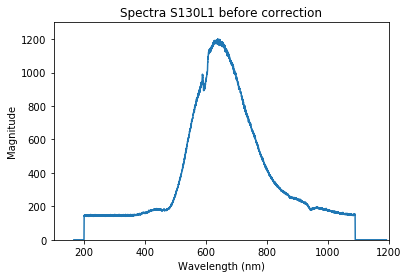

In [33]:
# Plot raw data with a solid line
plt.plot(wavel,image1, '-');

# Set axis limits to include origin
plt.xlim(100,1200)
plt.ylim(0,1300);

# Add axis labels
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude');

# Add legend
## plt.legend(['Data','100 $\Omega$'])

# Add title
plt.title('Spectra S130L1 before correction');

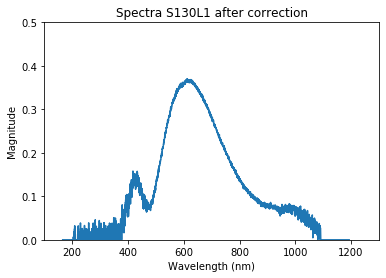

In [32]:
# Plot cleaned data with a solid line
plt.plot(wavel,final, '-');

# Set axis limits to include origin
plt.xlim(100,1300)
plt.ylim(0,.5);

# Add axis labels
plt.xlabel('Wavelength (nm)')
plt.ylabel('Magnitude');

# Add legend
## plt.legend(['Data','100 $\Omega$'])

# Add title
plt.title('Spectra S130L1 after correction');

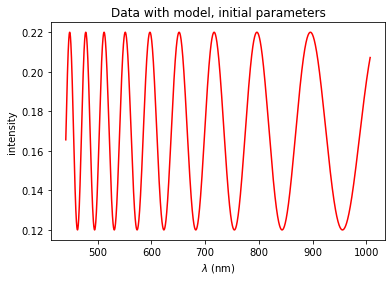

In [69]:
## Begin fitting by declaring model fitting function

def model(a,b,d,x):
    n = 2.39
    reflectance = a+b*np.cos(d*n*4*3.14/x)
    
    return reflectance
## a and b are constants, d is thickness, x is wavelength, n is refractive index of material (2.39?)

## set initial param. values below based on existing data 2018-2019

ainit = .17
binit =.05
dinit = 1500
## index depends on material (2.39 used in existing data 2018-2019)
pinit = [ainit,binit,dinit]
## plot model with inital parameters
## cut off start and end of data
xmodel = wavel [1000:3000]

plt.plot(xmodel,model(ainit,binit,dinit,xmodel),'r-')

# Label axes and give it a title for notebook (remove it when including the plot in a report)
plt.xlabel('$\\lambda$ (nm)')
plt.ylabel('intensity')
plt.title('Data with model, initial parameters')
plt.show()


In [71]:
## need to subtract background, and divide out ?noise? (see origin file)

yfit1 = image1[1000:3000] 

pOpt, pVar = curve_fit(model,xmodel,yfit1, p0 = pinit)

print (pOpt)
print(pVar)

[-1.78792613e+02  5.00000000e-02  1.50000000e+03]
[[ 1.61617635e+06 -1.20239667e+08  1.01080222e+13]
 [-1.20239667e+08  2.24248192e+10 -3.40289301e+14]
 [ 1.01080222e+13 -3.40289301e+14  7.58014463e+19]]
